# Test Run

In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import curvefit
from copy import deepcopy
from scipy import stats
from pprint import pprint
from curvefit.test_pipline import APModel
from curvefit.utils import get_derivative_of_column_in_log_space, get_obs_se
from curvefit.utils import truncate_draws, data_translator, convex_combination

## Control panel

In [2]:
# data
file_path_data = '../data/Slovakia.csv'
file_path_covariate = '../data/Slovakia covariate.csv'

In [3]:
# peaked groups
peaked_groups = [
    'Wuhan City, Hubei',
    'Piemonte',
    'Comunidad de Madrid',
    'Emilia-Romagna',
    'Toscana',
    'Liguria',
    'Lombardia',
    'King and Snohomish Counties (excluding Life Care Center), WA',
]

In [4]:
# basic information and model setting
basic_info_dict = dict(
    all_cov_names=['cov_1w'],
    col_t='Days',
    col_group='Location',
    predict_space=curvefit.log_derf,
    col_obs_compare='d ln(age-standardized death rate)',
    peaked_groups=peaked_groups
)

basic_model_dict = dict(
    param_names=['alpha', 'beta', 'p'],
    col_covs=[['intercept'], ['cov_1w'], ['intercept']],
    link_fun=[np.exp, lambda x: x, np.exp],
    var_link_fun=[lambda x: x, lambda x: x, lambda x: x]
)

In [5]:
# basic fit parameter
dummy_gprior = [0.0, np.inf]
dummy_uprior = [-np.inf, np.inf]
zero_uprior = [0.0, 0.0]
fe_init = np.array([-3, 28.0, -8.05])
fe_bounds = [[-np.inf, 0.0], [15.0, 100.0], [-10, -6]]
options = {
    'ftol': 1e-10,
    'gtol': 1e-10,
    'maxiter': 500,
    'disp': True
}

basic_fit_dict = dict(
    fe_init=fe_init,
    fe_bounds=fe_bounds,
    re_bounds=[zero_uprior]*3,
    fe_gprior=[dummy_gprior]*3,
    re_gprior=[dummy_gprior]*3,
    options=options
)

basic_joint_model_fit_dict = dict(
    fe_gprior=[dummy_gprior]*3,
    re_bounds=[dummy_uprior]*3,
    re_gprior=[dummy_gprior, [0.0, 10.0], dummy_gprior],
    smart_initialize=True,
    smart_init_options=options,
    options={
        'ftol': 1e-10,
        'gtol': 1e-10,
        'maxiter': 50,
        'disp': True
    }
)

In [6]:
# draw related paramters
draw_dict = dict(
    n_draws=100,
    prediction_times = np.arange(150),
    cv_threshold=1e-4,
    smoothed_radius=[2, 2],
    exclude_groups=['Wuhan City, Hubei'],
    exclude_below=0
)

# for the convex combination
start_day = 5
end_day = 10

# for prediction of places with no data
alpha_times_beta = np.exp(0.7)
obs_bounds = [25, np.inf] # filter the data rich models
predict_cov = np.array([1.0, 1.0, 1.0]) # new covariates for the places.

## Tight prior control panel

In [7]:
tight_info_dict = {
    **deepcopy(basic_info_dict),
    'fun': curvefit.log_erf,
    'col_obs': 'ln(age-standardized death rate)',
    'obs_se_func': lambda x: (1 / (1.0 + x)),
    'prior_modifier': lambda x: 10**(min(0.0, max(-1.0,
                0.1*x - 1.5
    ))),
#     'prior_modifier': lambda x: 10.0
}

In [8]:
tight_fit_dict = {
    **deepcopy(basic_fit_dict),
    'fun_gprior': [lambda params: params[0] * params[1], [np.exp(0.7), 0.1]]
}

In [9]:
# print summary
pprint(tight_info_dict)
print('-'*100)
pprint(tight_fit_dict)

{'all_cov_names': ['cov_1w'],
 'col_group': 'Location',
 'col_obs': 'ln(age-standardized death rate)',
 'col_obs_compare': 'd ln(age-standardized death rate)',
 'col_t': 'Days',
 'fun': <function log_erf at 0x1013430598>,
 'obs_se_func': <function <lambda> at 0x1a13c3a378>,
 'peaked_groups': ['Wuhan City, Hubei',
                   'Piemonte',
                   'Comunidad de Madrid',
                   'Emilia-Romagna',
                   'Toscana',
                   'Liguria',
                   'Lombardia',
                   'King and Snohomish Counties (excluding Life Care Center), '
                   'WA'],
 'predict_space': <function log_derf at 0x10134306a8>,
 'prior_modifier': <function <lambda> at 0x1a13c3a400>}
----------------------------------------------------------------------------------------------------
{'fe_bounds': [[-inf, 0.0], [15.0, 100.0], [-10, -6]],
 'fe_gprior': [[0.0, inf], [0.0, inf], [0.0, inf]],
 'fe_init': array([-3.  , 28.  , -8.05]),
 'fun_gprior': [

## Loose prior control panel

In [10]:
loose_info_dict = {
    **deepcopy(basic_info_dict),
    'fun': curvefit.log_erf,
    'col_obs': 'ln(age-standardized death rate)',
    'obs_se_func': lambda x: (1 / (0.1 + x**2)),
    'prior_modifier': lambda x: 1.0,
}

In [11]:
loose_fit_dict = {
    **deepcopy(basic_fit_dict),
    'fun_gprior': [lambda params: params[0] * params[1], dummy_gprior]
}

In [12]:
# print summary
pprint(loose_info_dict)
print('-'*100)
pprint(loose_fit_dict)

{'all_cov_names': ['cov_1w'],
 'col_group': 'Location',
 'col_obs': 'ln(age-standardized death rate)',
 'col_obs_compare': 'd ln(age-standardized death rate)',
 'col_t': 'Days',
 'fun': <function log_erf at 0x1013430598>,
 'obs_se_func': <function <lambda> at 0x1a13c3abf8>,
 'peaked_groups': ['Wuhan City, Hubei',
                   'Piemonte',
                   'Comunidad de Madrid',
                   'Emilia-Romagna',
                   'Toscana',
                   'Liguria',
                   'Lombardia',
                   'King and Snohomish Counties (excluding Life Care Center), '
                   'WA'],
 'predict_space': <function log_derf at 0x10134306a8>,
 'prior_modifier': <function <lambda> at 0x1a13c3a1e0>}
----------------------------------------------------------------------------------------------------
{'fe_bounds': [[-inf, 0.0], [15.0, 100.0], [-10, -6]],
 'fe_gprior': [[0.0, inf], [0.0, inf], [0.0, inf]],
 'fe_init': array([-3.  , 28.  , -8.05]),
 'fun_gprior': [

## Load data

In [13]:
df = pd.read_csv(file_path_data)
df_cov = pd.read_csv(file_path_covariate)

df_cov = df_cov.rename(columns={'location': 'Location'})
df = pd.merge(df, df_cov, on='Location', how='inner').copy()

df['intercept'] = 1.0
df = get_derivative_of_column_in_log_space(df,
                                           col_t=basic_info_dict['col_t'],
                                           col_obs=tight_info_dict['col_obs'],
                                           col_grp=basic_info_dict['col_group'])
df['daily deaths'] = np.exp(df['d ' + tight_info_dict['col_obs']])

In [14]:
# locations = ['California', 'Abruzzo', 'Arkansas'] + basic_info_dict['peaked_groups']
# df = df[df['Location'].isin(locations)].copy()

## Create models

In [15]:
tight_model = APModel(
    all_data=df,
    **tight_info_dict,
    joint_model_fit_dict=basic_joint_model_fit_dict,
    basic_model_dict=basic_model_dict,
    fit_dict=tight_fit_dict
)

Overriding fe_init with [-2.49472121 24.94638041 -8.51503884].
Overriding re_init with [-0.05845352  0.27565025  0.43756421 -0.20579049 -4.56488028 -0.57234887
  0.08084921  0.37928005  0.08715507 -0.05896037  1.81542486  1.18477236
  0.00597866  1.66004311 -0.07440036  0.41094309 -3.19493044 -1.46525529
 -0.17456658  3.62941245  0.40251289].
update beta fe gprior to [24.947442534324395, 2.6857226262298024]
Overriding fe_init with [-2.49472121 24.94638041 -8.51503884].
Overriding re_init with [-0.05845352  0.27565025  0.43756421 -0.20579049 -4.56488028 -0.57234887
  0.08084921  0.37928005  0.08715507 -0.05896037  1.81542486  1.18477236
  0.00597866  1.66004311 -0.07440036  0.41094309 -3.19493044 -1.46525529
 -0.17456658  3.62941245  0.40251289].
update beta fe gprior to [24.947442534324395, 2.6857226262298024]


In [16]:
# tight_model.run(**draw_dict)
tight_model.models = tight_model.run_models(tight_model.all_data, tight_model.groups)

Abruzzo
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.6857226262298024], [0.0, inf]]
Alabama
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.5358721144575574], [0.0, inf]]
Alaska
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.26857226262298023], [0.0, inf]]
Albania
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 1.694576416256327], [0.0, inf]]
Andalucia
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.6857226262298024], [0.0, inf]]
Andorra
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.6746230223624916], [0.0, inf]]
Aragon
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.6857226262298024], [0.0, inf]]
Arizona
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 1.0692054356198546], [0.0, inf]]
Arkansas
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.5358721144575574], [0.0, inf]]
Asturias
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.685722626

Minnesota
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.6746230223624916], [0.0, inf]]
Mississippi
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.8493000662335255], [0.0, inf]]
Missouri
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.133345312652181], [0.0, inf]]
Molise
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.6857226262298024], [0.0, inf]]
Montana
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.26857226262298023], [0.0, inf]]
Murcia
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 1.3460498933302878], [0.0, inf]]
Navarre
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.6857226262298024], [0.0, inf]]
Nebraska
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 0.26857226262298023], [0.0, inf]]
Netherlands
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 2.6857226262298024], [0.0, inf]]
Nevada
	 update beta fe_gprior to [[0.0, inf], [24.947442534324395, 1.6

In [17]:
# tight_model.plot_draws(
#     prediction_times=draw_dict['prediction_times'], sharex=True, sharey=False)

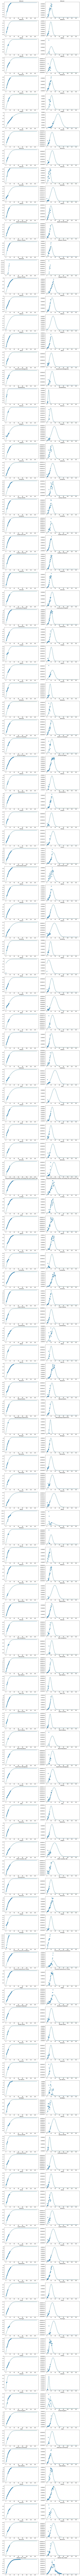

In [18]:
tight_model.plot_result(np.arange(150))

In [19]:
loose_model = APModel(
    all_data=df,
    **loose_info_dict,
    joint_model_fit_dict=basic_joint_model_fit_dict,
    basic_model_dict=basic_model_dict,
    fit_dict=loose_fit_dict
)

Overriding fe_init with [-2.52969881 25.49930127 -8.47299192].
Overriding re_init with [-0.03101809 -0.17944236  0.40347603 -0.22079372 -4.31176072 -0.52764309
  0.19515542 -1.26680045 -0.06202294 -0.05636036  1.75358193  1.18688796
 -0.10969504  4.32029123  0.14015861  0.45085178 -3.82078209 -1.51202898
 -0.22813999  3.50491245  0.37117241].
update beta fe gprior to [25.499301266496218, 3.136217383775884]
Overriding fe_init with [-2.52969881 25.49930127 -8.47299192].
Overriding re_init with [-0.03101809 -0.17944236  0.40347603 -0.22079372 -4.31176072 -0.52764309
  0.19515542 -1.26680045 -0.06202294 -0.05636036  1.75358193  1.18688796
 -0.10969504  4.32029123  0.14015861  0.45085178 -3.82078209 -1.51202898
 -0.22813999  3.50491245  0.37117241].
update beta fe gprior to [25.499301266496218, 3.136217383775884]


In [20]:
# loose_model.run(**draw_dict)
loose_model.models = loose_model.run_models(loose_model.all_data, loose_model.groups)

Abruzzo
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Alabama
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Alaska
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Albania
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Andalucia
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Andorra
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Aragon
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Arizona
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Arkansas
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Asturias
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], 

Mississippi
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Missouri
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Molise
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Montana
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Murcia
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Navarre
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Nebraska
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Netherlands
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
Nevada
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.136217383775884], [0.0, inf]]
New Hampshire
	 update beta fe_gprior to [[0.0, inf], [25.499301266496218, 3.1362173

In [21]:
# loose_model.plot_draws(
#     prediction_times=draw_dict['prediction_times'], sharex=True, sharey=False)

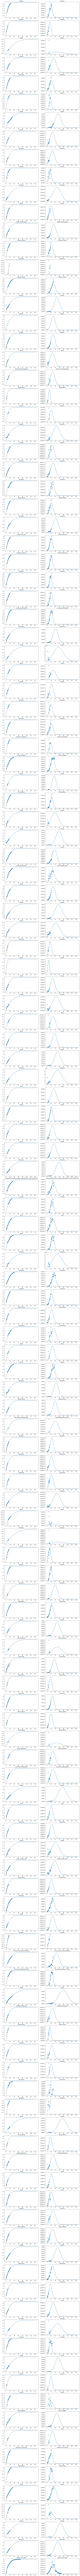

In [22]:
loose_model.plot_result(np.arange(150))